In [ ]:
!pip install --upgrade tensorflow
!pip install iterative-stratification

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Instanciando la red pre-entrenada VGG16 para aplicarla a la BD con expansión de imágenes pero esta vez con entonación fina

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import statistics
import pydot
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

from mlxtend.plotting import plot_confusion_matrix

conv_base  = keras.applications.inception_v3.InceptionV3(
    weights="imagenet",
    include_top=False)

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
!unzip /content/gdrive/MyDrive/TRABAJOGRADO/TRABAJO/ISICDatabase2.zip #comando linux

Archive:  /content/gdrive/MyDrive/TRABAJOGRADO/TRABAJO/ISICDatabase2.zip
  inflating: ISICDatabase2/Aleatoriodatabase.py  
   creating: ISICDatabase2/Test/
   creating: ISICDatabase2/Test/basal cell carcinoma/
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024331.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024332.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024345.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024360.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024403.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024411.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024431.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024432.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024436.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024443.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024448.jpg 

Ajustando los datos de la BD


In [ ]:
train_dataset = image_dataset_from_directory(
    'ISICDatabase2/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

validation_dataset = image_dataset_from_directory(
    'ISICDatabase2/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
test_dataset = image_dataset_from_directory(
    'ISICDatabase2/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

#normalization_layer = tf.keras.layers.Rescaling(1./255)
#train_dataset_n = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(train_dataset_n))

#normalization_layer = tf.keras.layers.Rescaling(1./255)
#validation_dataset_n = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(validation_dataset_n))

#normalization_layer = tf.keras.layers.Rescaling(1./255)
#test_dataset_n = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(test_dataset_n))


Found 1308 files belonging to 4 classes.
Found 325 files belonging to 4 classes.
Found 64 files belonging to 4 classes.


La fase de entrenamiento podrá alterar los pesos de las 4 últimas capas

In [ ]:
#@title La fase de entrenamiento podrá alterar los pesos de las 4 últimas capas
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalizati

Transformaciones para expandir las imágenes y definición de la arquitectura


In [ ]:
checkpoint_filepath = 'model20-12-2020_dp03031024.h5' #'/content'

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.6,
        patience=5,
        verbose=1,
        min_lr=1e-12),

    keras.callbacks.ModelCheckpoint(
        #filepath=checkpoint_filepath,
        filepath='model20-12-2020_dp03031024.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode = 'max',
        verbose=0,
        save_best_only=True)
]

In [ ]:


data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)



In [ ]:
def generate_model():
  inputs = keras.Input(shape=(180, 180, 3))
  x = data_augmentation(inputs)
  x = keras.applications.inception_v3.preprocess_input(x)
  x = conv_base(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(80,3,padding="same",activation="elu")(x)
  x = tf.keras.layers.Conv2D(40,3,padding="same",activation="elu")(x)
  x = tf.keras.layers.Conv2D(25,3,padding="same",activation="elu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = layers.Flatten()(x)
  x = layers.Dense(952, kernel_regularizer=regularizers.l1_l2(0.001), activation="elu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(4, activation="softmax")(x)
  model = keras.Model(inputs, outputs)
  return model

In [ ]:
model = generate_model()



model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"])
history = model.fit(
       train_dataset,
       epochs=30,
       batch_size=32,
       validation_data=validation_dataset,
       callbacks=callbacks_list)
print("--------------------------Test Results------------------------")


test_scores = model.evaluate(test_dataset, verbose=2)
print("Test Loss:", test_scores[0])
print("Test Accuracy:", test_scores[1])



Epoch 1/30
41/41 [==============================] - 27s 211ms/step - loss: 17.7452 - accuracy: 0.4106 - val_loss: 17.0334 - val_accuracy: 0.2892 - lr: 0.0010
Epoch 2/30
41/41 [==============================] - 5s 108ms/step - loss: 12.1566 - accuracy: 0.5619 - val_loss: 10.3521 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 3/30
41/41 [==============================] - 5s 111ms/step - loss: 8.0791 - accuracy: 0.5856 - val_loss: 6.8277 - val_accuracy: 0.5508 - lr: 0.0010
Epoch 4/30
41/41 [==============================] - 5s 105ms/step - loss: 5.4965 - accuracy: 0.5979 - val_loss: 4.5806 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 5/30
41/41 [==============================] - 5s 106ms/step - loss: 3.7379 - accuracy: 0.6361 - val_loss: 3.3240 - val_accuracy: 0.6092 - lr: 0.0010
Epoch 6/30
41/41 [==============================] - 5s 103ms/step - loss: 2.7654 - accuracy: 0.6583 - val_loss: 2.6534 - val_accuracy: 0.5815 - lr: 0.0010
Epoch 7/30
41/41 [==============================] - 5s 96ms/step 

In [ ]:
print("--------------------------Test Results------------------------")
print("Test Loss results:", Test_scores1)
print("Test Loss mean:", mean1)
print("Test Accuracy results:", Test_scores2)
print("Test Accuracy mean:", mean2)

--------------------------Test Results------------------------


NameError: ignored

In [ ]:
labels_fit = []
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_fit.append(np.asarray(label_batch))

labels_fit_matriz = np.concatenate(labels_fit)
labels_fit_matriz = np.array([np.argmax(i, axis = - 1) for i in labels_fit_matriz]).flatten()

Text(0.5, 1.0, 'Matriz de confusión promedio de los KFold')

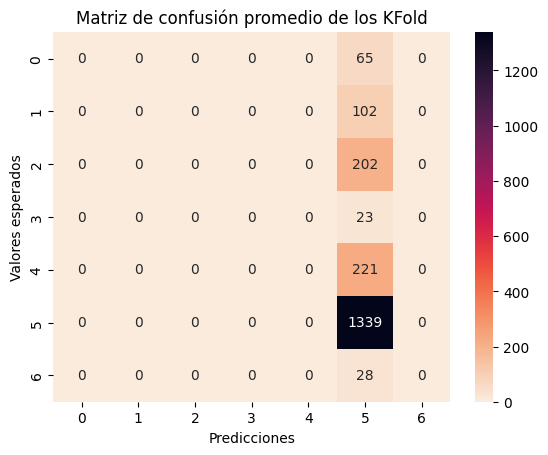

In [ ]:
matrices_de_confusión = []
for i in range(len(predicciones)):
  cf = metrics.confusion_matrix(labels_fit_matriz,predicciones[i])
  matrices_de_confusión.append(cf)

matriz_promedio = np.mean(matrices_de_confusión, axis=0, dtype=int)

sns.heatmap(matriz_promedio, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')
plt.title('Matriz de confusión promedio de los KFold')

In [ ]:
import tensorflow as tf

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.inception_v3.preprocess_input(x)
x = conv_base(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(80,3,padding="same",activation="elu")(x)
x = tf.keras.layers.Conv2D(40,3,padding="same",activation="elu")(x)
x = tf.keras.layers.Conv2D(25,3,padding="same",activation="elu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(952, kernel_regularizer=regularizers.l1_l2(0.001), activation="elu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 batch_normalization_197 (Ba  (None, 4, 4, 2048)       8192

Fijar los hiperparámetros y entrenar la red

In [ ]:
from keras.callbacks import EarlyStopping
checkpoint_filepath = 'model20-12-2020_dp03031024.h5' #'/content'
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        verbose=1,
        min_lr=1e-12),

    keras.callbacks.ModelCheckpoint(
        #filepath=checkpoint_filepath,
        filepath='model20-12-2020_dp03031024.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode = 'max',
        verbose=1,
        save_best_only=True)
]

history = model.fit(
    train_dataset,
    epochs=1000,  #30
    validation_data=validation_dataset,
    callbacks=callbacks_list)

Epoch 1/1000
50/50 [==============================] - ETA: 0s - loss: 20.6947 - accuracy: 0.2355
Epoch 1: val_accuracy improved from -inf to 0.30280, saving model to model20-12-2020_dp03031024.h5
50/50 [==============================] - 18s 200ms/step - loss: 20.6947 - accuracy: 0.2355 - val_loss: 20.1308 - val_accuracy: 0.3028 - lr: 1.0000e-05
Epoch 2/1000
49/50 [============================>.] - ETA: 0s - loss: 20.2166 - accuracy: 0.3399
Epoch 2: val_accuracy improved from 0.30280 to 0.41221, saving model to model20-12-2020_dp03031024.h5
50/50 [==============================] - 8s 153ms/step - loss: 20.2134 - accuracy: 0.3413 - val_loss: 19.9710 - val_accuracy: 0.4122 - lr: 1.0000e-05
Epoch 3/1000
49/50 [============================>.] - ETA: 0s - loss: 20.0308 - accuracy: 0.3807
Epoch 3: val_accuracy improved from 0.41221 to 0.44275, saving model to model20-12-2020_dp03031024.h5
50/50 [==============================] - 9s 169ms/step - loss: 20.0264 - accuracy: 0.3816 - val_loss: 19.

Visualizando la pérdida y el accuracy durante el entrenamiento


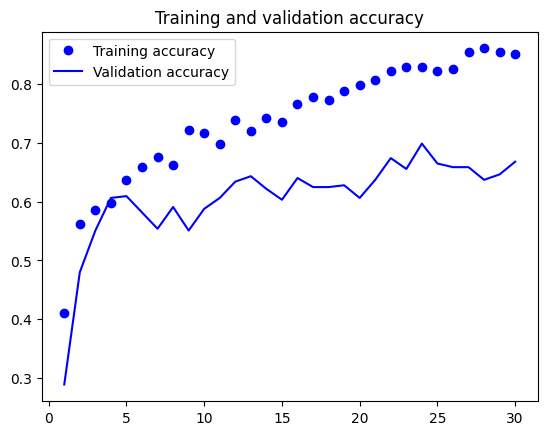

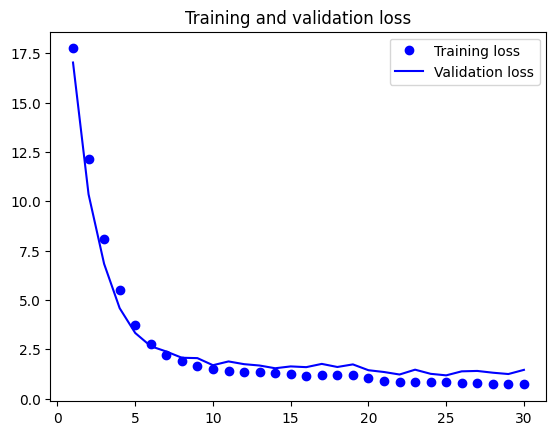

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
print("--------------------------Test Results------------------------")
test_scores = model.evaluate(test_dataset, verbose=2)
print("Test Loss:", test_scores[0])
print("Test Accuracy:", test_scores[1])

--------------------------Test Results------------------------
2/2 - 0s - loss: 1.7871 - accuracy: 0.6406 - 211ms/epoch - 106ms/step
Test Loss: 1.7871159315109253
Test Accuracy: 0.640625


### Matriz de confusión y métricas relevantes



In [ ]:
import numpy as np

In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_train = []  # store predicted labels
labels_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in train_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 1s 1s/step


In [ ]:
ultimo_label_train = labels_train.pop()
ultima_prediccion_train = predicciones_train.pop()

labels_train = np.array([np.argmax(i, axis = - 1) for i in labels_train]).flatten()
predicciones_train = np.array(predicciones_train).flatten()

ultimo_label_train = np.array([np.argmax(i, axis = - 1) for i in ultimo_label_train]).flatten()
labels_train = np.concatenate((labels_train, ultimo_label_train))
predicciones_train = np.concatenate((predicciones_train, ultima_prediccion_train))

[[280   3   3  15]
 [  8 251  55  37]
 [ 13   8 234  31]
 [  9   2   2 357]]


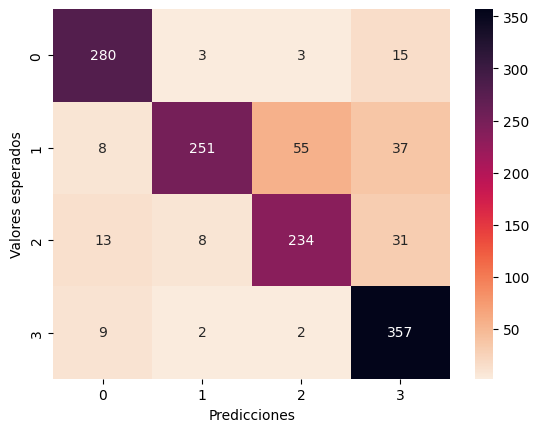

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       301
           1       0.95      0.72      0.82       351
           2       0.80      0.82      0.81       286
           3       0.81      0.96      0.88       370

    accuracy                           0.86      1308
   macro avg       0.87      0.86      0.86      1308
weighted avg       0.87      0.86      0.86      1308



In [ ]:
#predicciones_test = model.predict(images_test)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cf = metrics.confusion_matrix(labels_train,predicciones_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
#fig, ax = plot_confusion_matrix(conf_mat = cf)
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_train,predicciones_train))

In [ ]:
validation_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_val_train = []  # store predicted labels
labels_val_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_val_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_val_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 25ms/step


In [ ]:
ultimo_label_val_train = labels_val_train.pop()
ultima_prediccion_val_train = predicciones_val_train.pop()

labels_val_train = np.array([np.argmax(i, axis = - 1) for i in labels_val_train]).flatten()
predicciones_val_train = np.array(predicciones_val_train).flatten()

labels_val_train = np.concatenate((labels_val_train, np.argmax(ultimo_label_val_train, axis = - 1)))
predicciones_val_train = np.concatenate((predicciones_val_train, ultima_prediccion_val_train))

[[61  0  2 12]
 [ 4 39 29 15]
 [ 3  9 42 17]
 [ 7  6  4 75]]


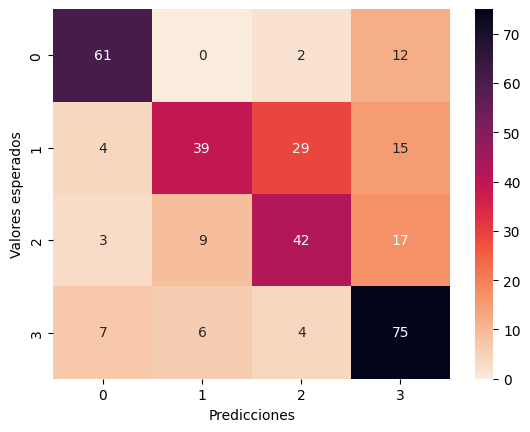

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        75
           1       0.72      0.45      0.55        87
           2       0.55      0.59      0.57        71
           3       0.63      0.82      0.71        92

    accuracy                           0.67       325
   macro avg       0.68      0.67      0.66       325
weighted avg       0.68      0.67      0.66       325



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_val_train,predicciones_val_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
#fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_val_train,predicciones_val_train))

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_test = []  # store predicted labels
labels_test = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_test.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_test.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 29ms/step


In [ ]:
ultimo_label_test = labels_test.pop()
ultima_prediccion_test = predicciones_test.pop()

labels_test = np.array([np.argmax(i, axis = - 1) for i in labels_test]).flatten()
predicciones_test = np.array(predicciones_test).flatten()

labels_test = np.concatenate((labels_test, np.argmax(ultimo_label_test, axis = - 1)))
predicciones_test = np.concatenate((predicciones_test, ultima_prediccion_test))

[[12  0  0  4]
 [ 0  3 11  2]
 [ 0  0 13  3]
 [ 2  1  0 13]]


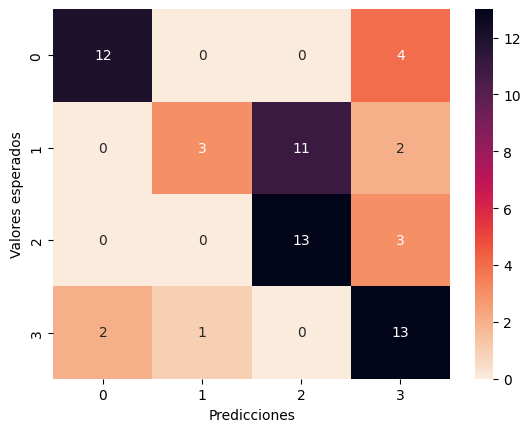

              precision    recall  f1-score   support

           0       0.86      0.75      0.80        16
           1       0.75      0.19      0.30        16
           2       0.54      0.81      0.65        16
           3       0.59      0.81      0.68        16

    accuracy                           0.64        64
   macro avg       0.68      0.64      0.61        64
weighted avg       0.68      0.64      0.61        64



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_test,predicciones_test)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')


## It canbe used in any platform
#fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_test,predicciones_test))

### Guardar el modelo con Tensorflow Lite para correr en Raspberry

In [ ]:
import tensorflow as tf
import pathlib

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
#tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir = pathlib.Path(".")
tflite_model_file = tflite_models_dir/"model_InceptionV3.tflite"
tflite_model_file.write_bytes(tflite_model)

94100180